In [1]:
import gym
import numpy as np
import torch
import torchkit.pytorch_utils as ptu
import torchsde
from torch.nn import functional as F
import random as rnd
import copy as cp
# import environments
import envs.pomdp
import pdb
# import recurrent model-free RL (separate architecture)
from policies.models.policy_rnn import ModelFreeOffPolicy_Separate_RNN as Policy_RNN
from policies.models.policy_rnn_shared import ModelFreeOffPolicy_Shared_RNN as Policy_Shared_RNN
from policies.models.policy_mlp import ModelFreeOffPolicy_MLP as Policy_MLP
from tqdm import tqdm
# import the replay buffer
from buffers.seq_replay_buffer_vanilla import SeqReplayBuffer
from buffers.simple_replay_buffer import SimpleReplayBuffer 
from utils import helpers as utl
from typing import Sequence
from read_ini import read_ini

C:\Users\alexander.vasilyev\Anaconda3\lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(
C:\Users\alexander.vasilyev\pomdp-baselines-main\utils\logger.py:9: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import OrderedDict, Set
C:\Users\alexander.vasilyev\Anaconda3\lib\site-packages\torch\utils\tensorboard\__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [5]:
conf =read_ini("C:/Users/alexander.vasilyev/pomdp-baselines-main/configfile.ini")

In [6]:
conf

{'env_name': 'Pendulum-V-v0',
 'algo_name': 'td3',
 'observ_embedding_size': '32',
 'action_embedding_size': '8',
 'reward_embedding_size': '8',
 'lr': '0.0003',
 'hidden_size': '72',
 'encoder': 'ncde',
 'activation': 'relu',
 'num_updates_per_iter': '1',
 'sampled_seq_len': '64',
 'buffer_size': '1e6',
 'batch_size': '32',
 'dropout_rate': '0.4',
 'num_iters': '500',
 'num_init_rollouts_pool': '5',
 'num_rollouts_per_iter': '5',
 '_n_env_steps_total': '0'}

## Build a POMDP environment: Pendulum-V (only observe the velocity)

In [11]:
cuda_id = 0  # -1 if using cpu
ptu.set_gpu_mode(torch.cuda.is_available() and cuda_id >= 0, cuda_id)

env = gym.make(conf["env_name"])
max_trajectory_len = env._max_episode_steps
act_dim = env.action_space.shape[0]
obs_dim = env.observation_space.shape[0]

shared = False
markov = False

if markov:
    agent = Policy_MLP(
        obs_dim=obs_dim,
        action_dim=act_dim,
        algo_name=conf["algo_name"],
        dqn_layers=[128, 128],
        policy_layers=[128, 128],
        lr=3e-4,
        gamma=0.99,
        tau=5e-3,
    ).to(ptu.device)
    encoder="Nan"
else:
    if shared:
        agent = Policy_Shared_RNN(
            obs_dim=obs_dim,
            action_dim=act_dim,
            encoder=conf["encoder"],
            algo_name=conf["algo_name"],
            action_embedding_size=int(conf["action_embedding_size"]),
            observ_embedding_size=int(conf["observ_embedding_size"]),
            reward_embedding_size=int(conf["reward_embedding_size"]),
            rnn_hidden_size=int(conf["hidden_size"]),
            dqn_layers=[128, 128],
            policy_layers=[128, 128],
            lr=float(conf["lr"]),
            gamma=0.9,
            tau=0.005,
            embed=True,
        ).to(ptu.device)
    else: 
        agent = Policy_RNN(
            obs_dim=obs_dim,
            action_dim=act_dim,
            encoder=conf["encoder"],
            algo_name=conf["algo_name"],
            action_embedding_size=int(conf["action_embedding_size"]),
            observ_embedding_size=int(conf["observ_embedding_size"]),
            reward_embedding_size=int(conf["reward_embedding_size"]),
            rnn_hidden_size=int(conf["hidden_size"]),
            dqn_layers=[128, 128],
            policy_layers=[128, 128],
            lr=float(conf["lr"]),
            gamma=0.9,
            tau=0.005,
            radii=60,
            embed=True,
            activation = conf["activation"],
        ).to(ptu.device)
    
print(agent)
encoder=conf["encoder"]
num_updates_per_iter = int(conf["num_updates_per_iter"])  # training frequency
sampled_seq_len = int(conf["sampled_seq_len"])  # context length
buffer_size = int(float(conf["buffer_size"]))
batch_size = int(conf["batch_size"])
dropout_rate=float(conf["dropout_rate"])
num_iters = int(conf["num_iters"])
num_init_rollouts_pool = int(conf["num_init_rollouts_pool"])
num_rollouts_per_iter = int(conf["num_rollouts_per_iter"])
total_rollouts = num_init_rollouts_pool + num_iters * num_rollouts_per_iter
n_env_steps_total = max_trajectory_len * total_rollouts
_n_env_steps_total = 0
print("total env episodes", total_rollouts, "total env steps", n_env_steps_total)


ModelFreeOffPolicy_Separate_RNN(
  (critic): Critic_RNN(
    (observ_embedder): FeatureExtractor(
      (fc): Linear(in_features=1, out_features=32, bias=True)
    )
    (action_embedder): FeatureExtractor(
      (fc): Linear(in_features=1, out_features=8, bias=True)
    )
    (reward_embedder): FeatureExtractor(
      (fc): Linear(in_features=1, out_features=8, bias=True)
    )
    (rnn): NeuralCDE(
      (func): CDEFunc(
        (linear0): Linear(in_features=72, out_features=72, bias=True)
        (linear1): Linear(in_features=72, out_features=72, bias=True)
        (linear2): Linear(in_features=72, out_features=3528, bias=True)
      )
      (initial): Linear(in_features=49, out_features=72, bias=True)
      (readout): Linear(in_features=72, out_features=72, bias=True)
    )
    (current_shortcut_embedder): FeatureExtractor(
      (fc): Linear(in_features=2, out_features=48, bias=True)
    )
    (qf1): FlattenMlp(
      (fc0): Linear(in_features=120, out_features=128, bias=True)
   

## Build a recurent model-free RL agent: separate architecture, `lstm` encoder, `oar` policy input space, `td3` RL algorithm (context length set later)

## Define other training parameters such as context length and training frequency

## Define key functions: collect rollouts and policy update

In [12]:
def create_ncde_row(obs, next_obs, prev_action, action, prev_reward, reward, steps,init):
    
    if init:
        obs_row= obs
        rew_row = prev_reward
        act_row = prev_action
    else:
        obs_row=torch.cat((obs, next_obs),0)
        rew_row=torch.cat((prev_reward, reward),0)
        act_row=torch.cat((prev_action, action),0)
 
    if shared: 
        obs_row=agent.observ_embedder(obs_row)
        rew_row=agent.reward_embedder(rew_row)
        act_row=agent.action_embedder(act_row)
    else: 
        obs_row=agent.actor.observ_embedder(obs_row)
        rew_row=agent.actor.reward_embedder(rew_row)
        act_row=agent.actor.action_embedder(act_row)
    
    if init:
        time_tensor=torch.tensor([[steps]]).to(ptu.device)
    else:
        time_tensor=torch.tensor([[steps],[steps+1]]).to(ptu.device)

    ncde_row=torch.cat((time_tensor,act_row,obs_row,rew_row),1)
    ncde_row=ncde_row[None,:]
    
    return ncde_row



@torch.no_grad()
def collect_rollouts(
    num_rollouts, random_actions=False, deterministic=True, train_mode=True
):
    """collect num_rollouts of trajectories in task and save into policy buffer
    :param
        random_actions: whether to use policy to sample actions, or randomly sample action space
        deterministic: deterministic action selection?
        train_mode: whether to train (stored to buffer) or test
    """
    if not train_mode:
        assert random_actions == False and deterministic == True

    total_steps = 0
    total_rewards = 0.0
    trewards =[]
    for idx in range(num_rollouts):
        steps = 0
        rewards = 0.0
        energy = 0.0
        print(env.reset())
        obs = ptu.from_numpy(env.reset())
        obs = obs.reshape(1, obs.shape[-1])
        done_rollout = False
        init=True
        # get hidden state at timestep=0, None for mlp
        
        if not markov:
            action, reward, internal_state = agent.get_initial_info()

            if encoder == "ncde":
                internal_state= None
                ncde_row= create_ncde_row(obs, obs, action, action, reward, reward, steps,init)
                prev_action= action.clone()
                prev_reward= reward.clone()
                next_obs= obs.clone()
        
        
        if train_mode:
            # temporary storage
            obs_list, act_list, rew_list, next_obs_list, term_list = (
                [],
                [],
                [],
                [],
                [],
            )
                           

        while not done_rollout:
            if markov: 
                action = agent.act(obs=obs, deterministic=deterministic)[0]
            else:
                if encoder == "ncde":
                    (action,_,_,_), internal_state= agent.ncde_act(ncde_row=ncde_row, prev_internal_state=internal_state, obs=obs,  deterministic=deterministic)
                else:
                    (action, _, _, _), internal_state = agent.act(
                        prev_internal_state=internal_state,
                        prev_action=action,
                        reward=reward,
                        obs=obs,
                        deterministic=deterministic,
                    )
            # observe reward and next obs (B=1, dim)
            #pdb.set_trace()
        
            #print(torch.norm(internal_state))
            next_obs, reward, done, info = utl.env_step(env, action.squeeze(dim=0))
            done_rollout = False if ptu.get_numpy(done[0][0]) == 0.0 else True
            init=False
            
            if not markov:
                if encoder == "ncde":
   
                    ncde_row= create_ncde_row(obs, next_obs, prev_action, action, prev_reward, reward, steps,init)
            
            #switch on/off dropouts
            #drop_trigger=rnd.uniform(0,1)
            #if drop_trigger<dropout_rate:
            #    next_obs=cp.deepcopy(obs)
            # update statistics
           
            rewards += reward.item()
            energy += action*action
           
            # early stopping env: such as rmdp, pomdp, generalize tasks. term ignores timeout
            term = (
                False
                if "TimeLimit.truncated" in info or steps >= max_trajectory_len
                else done_rollout
            )

            if train_mode:
                # append tensors to temporary storage
                obs_list.append(obs)  # (1, dim)
                act_list.append(action)  # (1, dim)
                rew_list.append(reward)  # (1, dim)
                term_list.append(term)  # bool
                next_obs_list.append(next_obs)  # (1, dim)
            steps += 1
            # set: obs <- next_obs
            obs = next_obs.clone()
            prev_reward= reward.clone()
            prev_action= action.clone()
        if train_mode:
            # add collected sequence to buffer
            policy_storage.add_episode(
                observations=ptu.get_numpy(torch.cat(obs_list, dim=0)),  # (L, dim)
                actions=ptu.get_numpy(torch.cat(act_list, dim=0)),  # (L, dim)
                rewards=ptu.get_numpy(torch.cat(rew_list, dim=0)),  # (L, dim)
                terminals=np.array(term_list).reshape(-1, 1),  # (L, 1)
                next_observations=ptu.get_numpy(
                    torch.cat(next_obs_list, dim=0)
                ),  # (L, dim)
            )
        print(
            "Mode:",
            "Train" if train_mode else "Test",
            "env_steps",
            steps,
            "total rewards",
            rewards,
            "total energy",
            energy,
        )
        total_steps += steps
        total_rewards += rewards
        trewards.append(rewards)
    if train_mode:
        return total_steps
    else:
        return total_rewards / num_rollouts, np.std(trewards)


def update(num_updates, factor):
    rl_losses_agg = {}
    # print(num_updates)
    for update in tqdm(range(num_updates), leave=True):
        # sample random RL batch: in transitions
        batch = ptu.np_to_pytorch_batch(policy_storage.random_episodes(batch_size))
        # RL update
        
        rl_losses = agent.update(batch, factor)

        for k, v in rl_losses.items():
            if update == 0:  # first iterate - create list
                rl_losses_agg[k] = [v]
            else:  # append values
                rl_losses_agg[k].append(v)
    # statistics
    for k in rl_losses_agg:
        rl_losses_agg[k] = np.mean(rl_losses_agg[k])
    return rl_losses_agg

## Train and Evaluate the agent: only costs < 20 min

In [13]:
policy_storage = SeqReplayBuffer(
    max_replay_buffer_size=buffer_size,
    observation_dim=obs_dim,
    action_dim=act_dim,
    sampled_seq_len=sampled_seq_len,
    sample_weight_baseline=0.0,
)

env_steps = collect_rollouts(
    num_rollouts=num_init_rollouts_pool, random_actions=False, train_mode=True
)
_n_env_steps_total += env_steps

# evaluation parameters
last_eval_num_iters = 10
log_interval = 5
eval_num_rollouts = 10
learning_curve = {
    "x": [],
    "y": [],
    "z": [],
}
epoch=0
lambda_pat = 0.65

while _n_env_steps_total < n_env_steps_total:

    env_steps = collect_rollouts(num_rollouts=num_rollouts_per_iter, train_mode=True)
    _n_env_steps_total += env_steps

    #train_stats = update(int(num_updates_per_iter * env_steps))
    factor= lambda_pat **(epoch )
    #train_stats = update(int(num_updates_per_iter * env_steps))
    train_stats = update(25, lr)
    
    epoch += 1
    current_num_iters = _n_env_steps_total // (
        num_rollouts_per_iter * max_trajectory_len
    )
    if (
        current_num_iters != last_eval_num_iters
        and current_num_iters % log_interval == 0
    ):
        last_eval_num_iters = current_num_iters
        average_returns, std_returns = collect_rollouts(
            num_rollouts=eval_num_rollouts,
            train_mode=False,
            random_actions=False,
            deterministic=True,
        )
        learning_curve["x"].append(_n_env_steps_total)
        learning_curve["y"].append(average_returns)
        learning_curve["z"].append(std_returns)
        print(_n_env_steps_total, average_returns)

buffer RAM usage: 0.02 GB
[-0.94829404]


C:\Users\alexander.vasilyev\Anaconda3\lib\site-packages\torch\nn\functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Mode: Train env_steps 200 total rewards -1885.8102731704712 total energy tensor([[0.0004]])
[0.15181476]
Mode: Train env_steps 200 total rewards -1610.5142149925232 total energy tensor([[0.0003]])
[-0.37681442]
Mode: Train env_steps 200 total rewards -1383.3761706352234 total energy tensor([[0.0006]])
[-0.7207371]
Mode: Train env_steps 200 total rewards -1827.4665489196777 total energy tensor([[0.0004]])
[0.58522725]
Mode: Train env_steps 200 total rewards -1641.2861404418945 total energy tensor([[0.0003]])
[0.98220396]


KeyboardInterrupt: 

## Draw the learning curve

{'x': [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000, 105000, 110000, 115000, 120000, 125000, 130000, 135000, 140000, 145000, 150000, 155000, 160000, 165000, 170000, 175000, 180000, 185000, 190000, 195000, 200000, 205000, 210000, 215000, 220000, 225000, 230000, 235000, 240000, 245000, 250000, 255000, 260000, 265000, 270000, 275000, 280000, 285000, 290000, 295000, 300000, 305000, 310000, 315000, 320000, 325000, 330000, 335000, 340000, 345000, 350000, 355000, 360000, 365000, 370000, 375000, 380000, 385000, 390000, 395000, 400000, 405000, 410000, 415000, 420000, 425000, 430000, 435000, 440000, 445000, 450000, 455000, 460000, 465000, 470000, 475000, 480000, 485000, 490000, 495000, 500000], 'y': [-1605.5890913292765, -1546.404285749793, -1563.8056536437944, -1410.3137237869203, -1369.2470292168728, -1437.0939343184232, -1401.9649479907007, -1513.5825214140118, -1557.005600644648, -1600.7387911051512

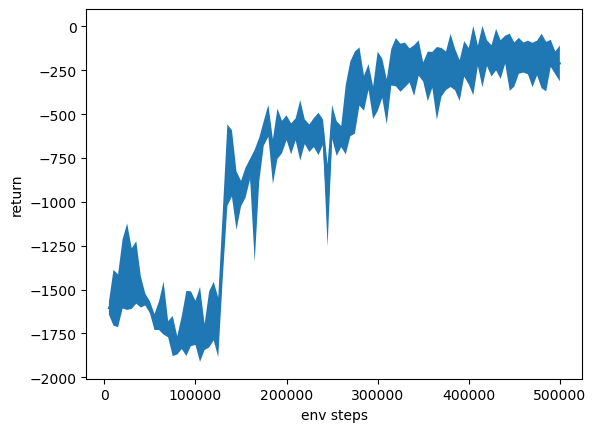

In [9]:
import matplotlib.pyplot as plt
print(learning_curve)
plt.plot(learning_curve["x"], learning_curve["y"])
plt.fill_between(np.array(learning_curve["x"]), np.array(learning_curve["y"])-np.array(learning_curve["z"]), np.array(learning_curve["y"])+np.array(learning_curve["z"]))
plt.xlabel("env steps")
plt.ylabel("return")
plt.show()

In [1]:
leaning_curve_ncde_64_rk4 = learning_curve

NameError: name 'learning_curve' is not defined

In [6]:
learning_curve_ncde_64= learning_curve


In [14]:
timess=torch.linspace(0, 65-1, 65)

In [10]:
learning_curve


{'x': [], 'y': []}

In [6]:
rnn = torch.nn.LSTM(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

In [7]:
output.size()



torch.Size([5, 3, 20])

In [5]:
def projection (x, y):
    
    proj= y*torch.sum(x*y)/(torch.norm(y)**2)
    
    return proj


In [11]:
x = torch.tensor([1.0,1.0])
y = torch.tensor([1.0,-1.0])

In [12]:
proj = projection(x,y)


In [13]:
proj

tensor([0., -0.])